In [1]:
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import kaggle
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from datetime import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelBinarizer, MultiLabelBinarizer
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import NearMiss
from numpy import where
import pickle



from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, recall_score
from sklearn.model_selection import GridSearchCV, validation_curve
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
from dask.distributed import Client

# Business Understanding

In the last decade, e-commerce has fundamentally changed how we live our lives through how we shop. Companies such as Sears have gone bankrupt over the years, making the transition from brick and mortar to an online e-commerce marketplace, however other companies such as Chewy, have been able to exploit e-commerce to become a market leader in their category.

A study by emarketer.com found that the pandemic has had beneficial effects on US e-commerce. Sales will reach $794.50 billion this year, up 32.4% year-over-year. That’s a much higher growth rate than the 18.0% predicted in our Q2 forecast, as consumers continue to avoid stores and opt for online shopping amid the pandemic. By the end of the year e-commerce sales will reach 14.4% of all US retail spending for the year and 19.2% by 2024. If you further dig into the data and exclude gas and auto sales (categories sold almost exclusively offline), ecommerce penetration jumps to 20.6%.(1)

With e-commerce growing at such an unprecedented rate, many companies are to capitalise on this change in consumer behaviour. It comes as no surprise to many that purchasing items online is a different process from buying an item in a store. While in a store an employee can help guide a customer to items they are both looking for and items they may want to consider purchasing, many e-commerce marketplaces dont have the same leverage; it's much easier to close out of a "You should buy" popup, rather than to ignore the advice of an instore expert. 

This has presented a serious challenge to e-commerce stores in the form of cart abandonment. Cart abandonment is when a customer leaves without buying, after adding an item to their cart. It is a trend that has remained steady since e-commerce entered the mainstream, as seen in the below chart from statista.

<a href="https://www.statista.com/statistics/477804/online-shopping-cart-abandonment-rate-worldwide/" rel="nofollow"><img src="https://www.statista.com/graphic/1/477804/online-shopping-cart-abandonment-rate-worldwide.jpg" alt="Statistic: Online shopping cart abandonment rate worldwide from 2006 to 2019 | Statista" style="width: 100%; height: auto !important; max-width:1000px;-ms-interpolation-mode: bicubic;"/></a><br />Find more statistics at  <a href="https://www.statista.com" rel="nofollow">Statista</a>

The good news for data scientists is that during an in store purchase a customer can have a large degree of privacy, while almost every move an online customer makes is tracked and stored in a series of databases. This data can be used to produce insights into customer purchasing behaviour, and spending patterns. Using the "eCommerce Events History in Cosmetics Shop" on kaggle (3) https://www.kaggle.com/mkechinov/ecommerce-events-history-in-cosmetics-shop we plan to analyse the purchasing patterns in the five month history the dataset provides and predict wether a customer is going to remove an item from their cart. With this knowledge a company can then provide incentives, such as free shipping or discounts to turn that removal into a purchase.

# Data Understanding

The kaggle e-commerce dataset contains behavior data for five months (Oct 2019 – Feb 2020) from a medium sized unnamed cosmetics online store. Each row in the file represents an online event or action. All events are related to products and users.

The dataset contains the following features:
1. `event_time`: Time when event happened at (in UTC).
2. `event_type`: What action a customer took. For more information please see below.
3. `product_id`: ID of a product
4. `category_id`: Product's category ID
5. `category_code`: Product's category taxonomy (code name) if it was possible to make it. Usually present for meaningful categories and skipped for different kinds of accessories.
6. `brand`: Downcased string of brand name. Can be a nan value, if it was missed.
7. `price`: Float price of a product. Present.
8. `user_id`: Permanent user ID.
9. `user_session` :Temporary user's session ID. Same for each user's session. This value is changed every time user come back to online store from a long pause.


`event_type` is further broken up into four components, these are:
1. view - a user viewed a product
2. cart - a user added a product to shopping cart
3. remove_from_cart - a user removed a product from shopping cart
4. purchase - a user purchased a product

An example of a purchase funnel, may be three chronological rows, with the rows sharing `user_session` and `user_id` values. Where the first row is a view, the second is cart, and the final is a purchase.


### Mission

I set out to build a machine learning model that can predict whether an item will be purchased or removed from the cart on an e-commerce store. This will be used to help in marketing, sales. On the supply chain side it will also give more insights into how a product is viewed by customers and how much a brand/product should be stocked or not.

# Importing and preparing the data

First we need to read the CSVs from our data folder and turn them into Pandas DataFrames for functionality. For a list of instructions on how to download the data form kaggle please see "../data/data_download.ipynb"

In [2]:
#Convert csv to DataFrame
oct19 = pd.read_csv("../data/2019-Oct.csv")
nov19 = pd.read_csv("../data/2019-Nov.csv")
dec19 = pd.read_csv("../data/2019-Dec.csv")
jan20 = pd.read_csv("../data/2020-Jan.csv")
feb20 = pd.read_csv("../data/2020-Feb.csv")

Now we have to combine each DataFrame that represents a month into one DataFrame that holds all the months data.

In [3]:
ecom_df = pd.concat([oct19, nov19, dec19, jan20, feb20], axis=0)
print(ecom_df.shape)

(20692840, 9)


Dropping columns here to both save memory latter on, also they are irrelevant to our data as we are only looking at purhcased, or removed from cart event_types.

In [4]:
ecom_df = ecom_df[ecom_df.event_type != 'view']
ecom_df = ecom_df[ecom_df.event_type != 'cart']
print(ecom_df.shape)

(5266686, 9)


# Data Cleaning

Before we start working with the data we need to make sure the dataset is in a workable state.

### NAs

Renaming unknown values in the brand column with the string 'Unknown'.

In [5]:
ecom_df.brand.fillna(value="unknown", axis=0, inplace=True)

Dropping the remaining NA's in the dataset.

In [6]:
ecom_df.dropna(inplace=True)

### Tidying the DataFrame

Dropping category_id, as we will use category code instead. It is redundant.

In [7]:
ecom_df.drop("category_id", axis=1, inplace = True)

Removing any negative prices that appear in the dataset.

In [8]:
ecom_df = ecom_df[ecom_df['price']>= 0]

Setting our target variable, `event_type` to binary.

In [9]:
ecom_df.event_type = ecom_df["event_type"].replace({'purchase': 0, 'remove_from_cart': 1})

In [10]:
ecom_df.shape

(55663, 8)

# Feature Engineering

As our DataFrame doesn't have many feautres, we will have to build out our own features to help our models perform better. As we have a timestamp for every event, we will start with Feature Engineering using time.

### Time Based Features

First we convert our event_time into a datatime object to allow us to have more functionality with the column.

In [11]:
ecom_df['event_time'] = pd.to_datetime(ecom_df['event_time'])

The first feature we will add, is if an event happened on a Holiday. It seems reasonable that people may be more inclined to spend money when they have the day off work.

In [12]:
dr = pd.date_range(start='2019-10-01', end='2020-02-29')
df = pd.DataFrame()
df['Date'] = dr

cal = calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())
ecom_df['holiday'] = ecom_df['event_time'].isin(holidays)

We now will pull from the `event_time` column three new columns:
1. What month was the event during?
2. Was the event in 2020 or 2019?
3. What hour of the day is the event taken place during?

In [13]:
ecom_df['month'] = pd.DatetimeIndex(ecom_df['event_time']).month
ecom_df['2020'] = pd.DatetimeIndex(ecom_df['event_time']).year
ecom_df['hour'] = pd.DatetimeIndex(ecom_df['event_time']).hour

#converting the year to binary
ecom_df['2020'] = ecom_df['2020'].replace({2019: 0, 2020: 1})

#converting month to string
ecom_df['month'] = ecom_df['month'].replace({1: 'January', 2: 'Febuary', 10: 'October', 11: 'November', 12: 'December'})

Now to add a feature, on what day of the week will a purchase take place.

In [14]:
ecom_df['day'] = ecom_df['event_time'].dt.dayofweek
ecom_df['day'] = ecom_df['day'].replace({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})

Creating four bins, we will also establish a feature that describes at what period of the day did an event happen:
1. Night: Midnight -> 6am
2. Morning: 6am -> Midday
3. Afternoon: Midday -> 6pm 
4. Evening: 6pm ->Midnight

In [15]:
#creating new when dataframe
when_df = pd.DataFrame({'hour':range(1, 25)})
bins = [0,6,12,18,24]
labels = ['Night', 'Morning','Afternoon','Evening']
when_df['when'] = pd.cut(when_df['hour'], bins=bins, labels=labels, include_lowest=True)

#joining the new dataframe
ecom_df = ecom_df.join(when_df['when'], on="hour")

In [16]:
print(ecom_df.shape)

(55663, 14)


### Labeling

Now we will use LabelBinarizer and OneHotEncoder on several feature in the natives dataset, and several of the features we built above to create many new features

In [17]:
#Labeling
encoder = LabelBinarizer()
brand_labels = pd.DataFrame(encoder.fit_transform(ecom_df[['brand']]), columns=encoder.classes_, index=ecom_df.index)
encoder2 = LabelBinarizer()
productid_labels = pd.DataFrame(encoder2.fit_transform(ecom_df[["product_id"]]), columns=encoder2.classes_, index=ecom_df.index)

#OHE
ohe = OneHotEncoder(sparse=False, drop='first')
catco_labels = pd.DataFrame(ohe.fit_transform(ecom_df[['category_code']]), index=ecom_df.index, columns=ohe.get_feature_names(ecom_df[["category_code"]].columns))
ohe = OneHotEncoder(sparse=False, drop='first')
day_labels = pd.DataFrame(ohe.fit_transform(ecom_df[['day']]), index=ecom_df.index, columns=ohe.get_feature_names(ecom_df[["day"]].columns))
ohe = OneHotEncoder(sparse=False, drop='first')
month_labels = pd.DataFrame(ohe.fit_transform(ecom_df[['month']]), index=ecom_df.index, columns=ohe.get_feature_names(ecom_df[["month"]].columns))
ohe = OneHotEncoder(sparse=False, drop='first')
when_labels = pd.DataFrame(ohe.fit_transform(ecom_df[['when']]), index=ecom_df.index, columns=ohe.get_feature_names(ecom_df[["when"]].columns))

#join the dataframes together
ecom_df = ecom_df.join(brand_labels)
ecom_df = ecom_df.join(productid_labels)
ecom_df = ecom_df.join(catco_labels)
ecom_df = ecom_df.join(day_labels)
ecom_df = ecom_df.join(month_labels)
ecom_df = ecom_df.join(when_labels)

In [18]:
print(ecom_df.shape)

(93421, 555)


# Preprocessing Data

Now are data has been cleaned up and the new features we wanted to add have been built, we now need to establish what our target column is and set it to y, with our predictors being set to X.

We will also need to drop our features in `ecom_df` that we have encoded or are redundant.

As our `event_type` column has already been converted to binary we can set it to y.

### Train Test Split

In [19]:
X = ecom_df.drop(["month", "hour", "day", "when", "user_id", "product_id", "category_code", "event_time", "event_type", "brand", "user_session"], axis=1)
y = ecom_df.event_type

We will also check out y classes to see if there is a class imbalance.

In [20]:
y.value_counts()

1    65903
0    27518
Name: event_type, dtype: int64

In [21]:
ecom_df.shape

(93421, 555)

We can see there is a class imbalance. We will have to account for this before we model.

Now that our data has been seperated we need to split the data into a train and test set.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### SMOTE

As we have a class imbalance of roughly 2:1 in favour of our `removed_from_cart` category we will smote our training data to help our models perform more accurately.

In [23]:
sm = SMOTE(random_state=42)
X_tr_sm, y_tr_sm = sm.fit_resample(X_train, y_train)

In [24]:
X_tr_sm.shape

(105456, 544)

# Models

### LGBMClassifier

LGBM is one of the strongest, if not the strongest, model on the market currently. I have had success with it before and wanted to start with a strong model to see what kind of results it can give as a benchmark.

In [25]:
import lightgbm as lgb

In [26]:
# Instantiate XGBClassifier
lgbm = lgb.LGBMClassifier()

# Fit XGBClassifier
lgbm.fit(X_tr_sm,  y_tr_sm)

# Predict on training and test sets
training_preds_lgbm = lgbm.predict(X_tr_sm)
test_preds_lgbm = lgbm.predict(X_test)

# Printing the Classification Report to see how our model performed
first_results=classification_report(y_test, test_preds_lgbm)
print(first_results)

              precision    recall  f1-score   support

           0       0.53      0.56      0.55      5510
           1       0.81      0.79      0.80     13175

    accuracy                           0.72     18685
   macro avg       0.67      0.68      0.67     18685
weighted avg       0.73      0.72      0.73     18685



While LGBM gave great results with default hyperparameters, I wanted to try some different models first.

### DecisionTreeClassifier

Our next model was a Decision Tree. We wanted something to compare to XGBoost that was a little bit more simple but still could deal with complex models. We also wanted a model that could execute faster than XGBoost.

In [27]:
tree_clf = DecisionTreeClassifier() 

tree_clf.fit(X_tr_sm, y_tr_sm)

# Predict on training and test sets
training_preds_tclf = tree_clf.predict(X_tr_sm)
test_preds_tclf = tree_clf.predict(X_test)

# Printing the Classification Report to see how our model performed
first_results=classification_report(y_test, test_preds_tclf)
print(first_results)

              precision    recall  f1-score   support

           0       0.57      0.64      0.60      5510
           1       0.84      0.80      0.82     13175

    accuracy                           0.75     18685
   macro avg       0.71      0.72      0.71     18685
weighted avg       0.76      0.75      0.76     18685



### RandomForestClassifier

While RandomForest usually performs worse than LGBM, I wanted to do my due dilligence and test the models performance first.

In [28]:
rf = RandomForestClassifier()

rf.fit(X_tr_sm, y_tr_sm)

# Predict on training and test sets
training_preds_rf = rf.predict(X_tr_sm)
test_preds_rf = rf.predict(X_test)

# Printing the Classification Report to see how our model performed
first_results=classification_report(y_test, test_preds_rf)
print(first_results)

              precision    recall  f1-score   support

           0       0.60      0.61      0.61      5510
           1       0.84      0.83      0.83     13175

    accuracy                           0.77     18685
   macro avg       0.72      0.72      0.72     18685
weighted avg       0.77      0.77      0.77     18685



# Hyperparamter Tuning

We have established that our RandomForestClassifier appears to be the best performing model at baseline. The next step is to adjust certain parameters to help improve the quality of our model. 

Warning: this grid will take a while to run.

In [29]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 95, 110, 115, 120],
    'max_features': [2, 3, 7, 10, 30, 50, 100, 150],
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 300, 400]}

In [30]:
# Instantiate the grid search model
clf = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
clf.fit(X_tr_sm, y_tr_sm)
GridSearchCV(estimator=rf,
             param_grid=param_grid)

NameError: name 'rf3' is not defined

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [ ]:
# Fit the grid search to the data
print(clf.best_params_)
best_grid = clf.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)
print(grid_accuracy)

# Best Model

After running the param_grid in our HyperParameter step, we established that the best model is as follows:
RandomForestClassifier with:
1. criterion: gini
2. max_depth: 115
3. max_features: 100
4. n_estimators: 400
5. bootstrap: True

In [39]:
Best_model = RandomForestClassifier(bootstrap= True, criterion= 'gini', max_depth= 115, max_features= 100, n_estimators= 400)

Best_model.fit(X_tr_sm, y_tr_sm)

# Predict on training and test sets
training_preds_bm = Best_model.predict(X_tr_sm)
test_preds_bm = Best_model.predict(X_test)

# Printing a classifcation report for our best model
print(classification_report(y_tr_sm, training_preds_bm))
print(classification_report(y_test, test_preds_bm))

# Saving y preds train
y_pred_tr = pd.DataFrame(data=y_pred_best, columns=y_train.columns, index=y_train.index)
y_pred_tr.to_csv('../data/best_y_preds.csv')

# Saving y preds test
training_preds_bm = pd.DataFrame(data=y_pred_test, columns=y_test.columns, index=y_test.index)
test_preds_bm.to_csv('../data/y_preds_test.csv')

              precision    recall  f1-score   support

           0       0.90      0.90      0.90     52728
           1       0.90      0.90      0.90     52728

    accuracy                           0.90    105456
   macro avg       0.90      0.90      0.90    105456
weighted avg       0.90      0.90      0.90    105456

              precision    recall  f1-score   support

           0       0.61      0.62      0.62      5510
           1       0.84      0.84      0.84     13175

    accuracy                           0.77     18685
   macro avg       0.73      0.73      0.73     18685
weighted avg       0.77      0.77      0.77     18685



NameError: name 'y_pred_best' is not defined

# Visuals

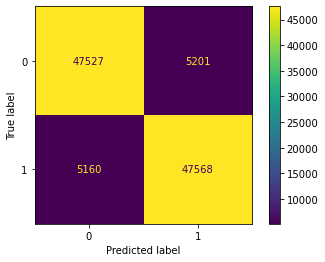

In [34]:
#confusion matrix
plot_confusion_matrix(estimator=Best_model, y_true=y_tr_sm, X=X_tr_sm)
plt.savefig("conufsion_matrix_train")

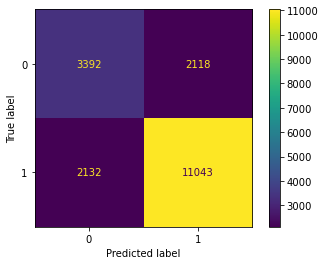

In [35]:
#confusion matrix
plot_confusion_matrix(estimator=Best_model, y_true=y_test, X=X_test)
plt.savefig("conufsion_matrix_test")